# How KANs Learn ?

This notebook extends the ["How different machine learning models generalize?"](https://ydf.readthedocs.io/en/latest/blog/2024/10/04/how-different-machine-learning-models-generalize/) blog post [4] to KANs (**Kolmogorov-Arnold Networks**) [1], demonstrating how they "learn", by creating a 2-D image with figures, and try to make KAN models (with various univariate functions) learn them, given the input x/y.

The following KAN univariate functions are evaluated:

1. B-Spline KAN: the univariate function used in the original KAN paper [1].
2. GR-KAN (Group Rational KAN): Published in the KAT paper [2].
3. PWL-KAN (Piecewise Linear KAN): A KAN that uses piecewise linear functions.
4. PWC-KAN (Piecewise Constant KAN) or Discrete-KAN: A KAN that uses piecewise-constant functions (staircase functions), see demo in [3].

* [1] ['Kolmogorov-Arnold Networks" (arxiv.org/abs/2404.19756)](https://arxiv.org/abs/2404.19756)
* [2] ["KAT: A Knowledge Augmented Transformer for Vision-and-Language" (arxiv.org/abs/2112.08614)](https://arxiv.org/abs/2112.08614)
* [3] [Discrete-KAN](https://gomlx.github.io/gomlx/notebooks/discrete-kan.html)
* [4] ["How different machine learning models generalize?"](https://ydf.readthedocs.io/en/latest/blog/2024/10/04/how-different-machine-learning-models-generalize/)

This notebook was created using [GoNB](https://github.com/janpfeifer/gonb) a Go kernel for Jupyter notebooks, and [GoMLX](https://github.com/gomlx/gomlx), a machine learning framework for Go, using XLA as a backend.

## Imports and setup code

Details, not needed for understanding, so kept hidden.

In [1]:
%version
!*rm -f go.work && go work init
!*go work use . "${HOME}/Projects/gonb" "${HOME}/Projects/gomlx" "${HOME}/Projects/gopjrt"
%goworkfix

**GoNB** version [v0.10.6](https://github.com/janpfeifer/gonb/releases/tag/v0.10.6) / Commit: [0e5f587a077810d058202b76a127651a02bd4382](https://github.com/janpfeifer/gonb/tree/0e5f587a077810d058202b76a127651a02bd4382)


	- Added replace rule for module "github.com/gomlx/gomlx" to local directory "/home/janpf/Projects/gomlx".
	- Added replace rule for module "github.com/janpfeifer/gonb" to local directory "/home/janpf/Projects/gonb".
	- Added replace rule for module "github.com/gomlx/gopjrt" to local directory "/home/janpf/Projects/gopjrt".


In [2]:
import (
    "math"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/backends"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/ml/train/losses"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/tensors"
    "github.com/gomlx/gopjrt/dtypes"
    "github.com/janpfeifer/gonb/gonbui"
    "github.com/janpfeifer/gonb/cache"

    // Include XLA engine for the demo.
    _ "github.com/gomlx/gomlx/backends/default"
)

// Backend used everywhere. Default will use GPU if available, otherwise CPU.
var Backend = backends.MustNew()

// Makes sure there is a valid reference to `graph` package imported inline.
var _ = Add

// Define how we want to fail in case of errors.
func init_must() {
    must.M = func(err error) {
        if err != nil {
            log.Fatal("Error:\n%+v\n", err)
        }
    }
}


## Plotting Code

We are plotting functions $f(x,y) \text{ where } x, y \in [-1, 1]$. The output of $f(x,y) \in [0, 1]$ represents a degree of grayness 0.0 representing white and 1.0 representing black.

The functions are given GoMLX functions, that take as input one array shaped `[batch_size, 2]` (`batch_size` pairs of $(x, y)$).



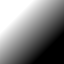

In [3]:
// PlotFn is the function accepted by the plot functions.
//
// The function takes as an input shaped [batch_size, 2], with batch_size tuples of (x, y), and should return `[batch_size, 1]`
// values from 0.0 to 1.0 
//
// The context holds the variables of the model (for learned functions), but can be ignored if the function doesn't use any variables.
type PlotFn func (ctx *context.Context, xys *Node) *Node 

// PlotToImg returns the HTML `<img src=...>` of size "size x size", with the plotted function, that can be displayed or composed.
//
// The context can be nil, if the function doesn't use any variables.
func PlotToImg(ctx *context.Context, fn PlotFn, size int) string {
    if ctx == nil {
        ctx = context.New()
    }
    ctx = ctx.Reuse()  // When plotting, we shouldn't be creating new variables. This way it will fail if function is not yet trained.
    // Generate values for each pixel, shaped [size * size, 1]
    values := context.ExecOnce(Backend, ctx, func (ctx *context.Context, g *Graph) *Node {
        xys := imgXYs(g, size)
        output := fn(ctx, xys)
        return ClipScalar(output, 0.0, 1.0)  // Clip to the values allowed.
    })

    
	img := image.NewGray(image.Rect(0, 0, size, size))
    tensors.ConstFlatData[float32](values, func (data []float32) {
    	for i, v := range data {
    		// Convert float32 (0.0 - 1.0) to uint8 (0 - 255)
    		grayValue := uint8((1.0 - v) * 255)  // Colors reversed, so black is 1.0, white is 0.0 (better for white backgrounds).
    		y := (i / size)
    		x := i % size
    		img.SetGray(x, y, color.Gray{Y: grayValue})
    	}
    })
    
    imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))
    return fmt.Sprintf("<img src=%q/>", imgSrc)
}

// imgXYs creates all combination of (x, y) for an image of size (size x size), where $x,y \in [0, 1]$.
// The output is shaped [batchSize, 2], where batchSize = size * size.
func imgXYs(g *Graph, size int) *Node {
    xs := Iota(g, shapes.Make(dtypes.Float32, size, size, 1), 1) // -> 0, size-1
    xs = AddScalar(DivScalar(xs, float64(size)/2.0), -1)  // -> -1.0, 1.0
    ys := Iota(g, shapes.Make(dtypes.Float32, size, size, 1), 0)
    ys = AddScalar(DivScalar(ys, float64(size)/2.0), -1)  // -> -1.0, 1.0
    xys := Concatenate([]*Node{xs, ys}, -1)
    xys = Reshape(xys, size*size, 2)  // Contract width and height axes into a "batch_size" axis.
    return xys
}

// Plot displays an image generated from the given function.
func Plot(ctx *context.Context, fn PlotFn, size int) {
    gonbui.DisplayHTML(PlotToImg(ctx, fn, size))
}

%%
// Small test of a gradient function on the x,y diagonal.
Plot(nil, func (_ *context.Context, xys *Node) *Node {
    value := ReduceAndKeep(xys, ReduceSum, -1)  // x+y -> -2.0 to 2.0
    // -> -0.5 to 1.5, but values will be clipped.
    return AddScalar(DivScalar(value, 2.0), 0.5)
}, 64)


## Ground-Truth Image

This is the image we want the various machine learning functions to learn, based on [4].



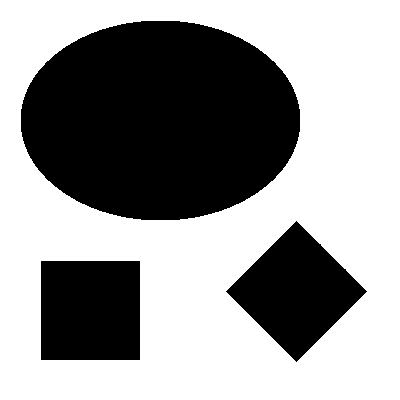

In [4]:
func GroundTruth(_ *context.Context, xys *Node) *Node {
    g := xys.Graph()
    dtype := xys.DType()
    
    xs := Slice(xys, /*batch_size*/ AxisRange(), /* (x,y) */ AxisElem(0)) // xs -> [-1, 1]
    xs = DivScalar(OnePlus(xs), 2)  // xs -> [0, 1]
    ys := Slice(xys, /*batch_size*/ AxisRange(), /* (x,y) */ AxisElem(1)) // ys -> [-1, 1]
    ys = DivScalar(OnePlus(ys), 2)  // ys -> [0, 1]
    
    eclipse := Sqrt(Add(
        Square(DivScalar(AddScalar(xs, -0.4), 0.7)),
        Square(DivScalar(AddScalar(ys, -0.3), 0.5)),
    ))
    eclipse = LessThan(eclipse, Scalar(g, dtype, 0.5))

    w := 0.25
    squareLength := Scalar(g, dtype, w)
    squareLength2 := Scalar(g, dtype, w * math.Sqrt(2))

    xs1 := AddScalar(xs, -0.10)
    ys1 := AddScalar(ys, -0.65)
    zero := ScalarZero(g, dtype)
    square1 := And(
        And(GreaterThan(xs1, zero), LessThan(xs1, squareLength)),
        And(GreaterThan(ys1, zero), LessThan(ys1, squareLength)),
    )

    xs2, ys2 := AddScalar(xs, - 0.74), AddScalar(ys, -0.55)
    xs2, ys2 = Add(xs2, ys2), Sub(ys2, xs2)
    square2 := And(
        And(GreaterThan(xs2, zero), LessThan(xs2, squareLength2)),
        And(GreaterThan(ys2, zero), LessThan(ys2, squareLength2)),
    )
    
    image := Or(Or(eclipse, square1), square2)
    return ConvertDType(image, xys.DType())
}

%%
Plot(nil, GroundTruth, 400)

## Machine Learning a function to mimic `GroundTruth`

### Training and Validation Datasets

To analyse how a machine learning model "learns" (or "generalizes") the ground-truth image in an interesting way, we will create a fixed dataset with a limited number of examples, and then train the model.

Notice we generate the datset as a couple of fixed tensors, whose shapes are: 

* Input shape `[num_batches, batch_size, 2]`, with the $(x, y)$ of the data points. Notice `NumTrainingExamples = num_batches * batch_size`.
* Labels shape `[num_batches, batch_size, 1]`. While the labels are defined in the range `[0.0, 1.0]`, our ground-truth only uses 0s and 1s, so it can be consider a boolean.


In [5]:
const (
    TrainingDataSeed = 42
    NumTrainingExamples = 32_000
    NumValidationExamples = 16_000
)

// Upload training and validation data as a variables.
func UploadTrainingData(ctx *context.Context) {
    _ = context.ExecOnceN(Backend, ctx, func (ctx *context.Context, g *Graph) {
        rng := Const(g, RngStateFromSeed(TrainingDataSeed))
        var trainXYs, validXYs *Node
        rng, trainXYs = RandomUniform(rng, shapes.Make(dtypes.Float32, NumTrainingExamples, 2))  // -> [0, 1]
        rng, validXYs = RandomUniform(rng, shapes.Make(dtypes.Float32, NumTrainingExamples, 2))  // -> [0, 1]
        trainXYs = AddScalar(MulScalar(trainXYs, 2), -1)  // -> [-1, 1]
        validXYs = AddScalar(MulScalar(validXYs, 2), -1)  // -> [-1, 1]
        trainLabels := GroundTruth(ctx, trainXYs)
        validLabels := GroundTruth(ctx, validXYs)

        // Break up into batches.
        numBatches := context.GetParamOr(ctx, "num_batches", int(1))  // default to 1.
        batchSize := NumTrainingExamples / numBatches
        trainXYs = Reshape(trainXYs, numBatches, batchSize, 2)
        trainLabels = Reshape(trainLabels, numBatches, batchSize, 1)

        // Store data into (non-trainable) variables.
        _ = ctx.VariableWithValueGraph("trainXYs", trainXYs).SetTrainable(false)
        _ = ctx.VariableWithValueGraph("trainLabels", trainLabels).SetTrainable(false)
        _ = ctx.VariableWithValueGraph("validXYs", validXYs).SetTrainable(false)
        _ = ctx.VariableWithValueGraph("validLabels", validLabels).SetTrainable(false)
    })
}

%%
// Create a context, and check that variables with the training data were uploaded with the right shape.
ctx := context.New()
UploadTrainingData(ctx)
for v := range ctx.IterVariables() {
    fmt.Printf("%s: shape=%s\n", v.ScopeAndName(), v.Shape())
    tensors.ConstFlatData(v.Value(), func (flat []float32) {
        fmt.Printf("\tSample values: %v\n", flat[:10])
    })
}

/trainXYs: shape=(Float32)[1 32000 2]
	Sample values: [0.9253949 -0.7290534 0.40012693 0.011769533 0.24289417 -0.20978129 0.15292251 -0.09316999 0.96000326 -0.43578953]
/trainLabels: shape=(Float32)[1 32000 1]
	Sample values: [0 0 1 1 0 1 0 0 1 0]
/validXYs: shape=(Float32)[32000 2]
	Sample values: [-0.6587877 -0.9495033 0.28734863 0.8810971 0.63639426 0.5474998 0.8441943 -0.5901769 0.46686828 0.9806895]
/validLabels: shape=(Float32)[32000 1]
	Sample values: [0 0 1 0 0 1 1 0 1 0]


### Trivial Training Loop

Below we create a training loop and a couple of loss functions that uses the training data we just created.

It can be used by any model with may want to try to learn.

In [6]:
// Train the given learnable fn for numSteps. The context (ctx) will store the learned weights.
//
// Use one of the losses defined here, since we take the labels as generated by the model function (as opposed to given by the dataset).
func Train(ctx *context.Context, fn PlotFn, numSteps int, lossFn losses.LossFn) error {
    // Upload training data, if not yet set.
    v := ctx.InspectVariable("/", "trainXYs")
    if v == nil {
        UploadTrainingData(ctx)
    }
    ds := data.NewConstantDataset()
                       
    // Our model function: it gets the batch from the fixed inputs, and call the LearnableFn provides. 
    // It also returns the labels for the batch.
    modelFn := func(ctx *context.Context, spec any, inputs []*Node) []*Node {
        g := inputs[0].Graph()
        
        // Get training data, which must exist already in the context.
        trainXYs := ctx.InspectVariable("/", "trainXYs").ValueGraph(g)
        trainLabels := ctx.InspectVariable("/", "trainLabels").ValueGraph(g)
    
        // Get the batch for this global step.
        numBatches := trainXYs.Shape().Dim(0)
        batchSize := trainXYs.Shape().Dim(1)
        globalStep := optimizers.GetGlobalStepVar(ctx).ValueGraph(g)
        batchIdx := ModScalar(globalStep, numBatches)
        zeroIdx := ScalarZero(g, globalStep.DType())
        batchXYs := DynamicSlice(trainXYs, []*Node{batchIdx, zeroIdx, zeroIdx}, []int{1, batchSize, 2})
        batchXYs = Reshape(batchXYs, batchSize, 2)
        batchLabels := DynamicSlice(trainLabels, []*Node{batchIdx, zeroIdx, zeroIdx}, []int{1, batchSize, 1})
        batchLabels = Reshape(batchLabels, batchSize, 1)

        // Prediction
        logits := fn(ctx, batchXYs)
        return []*Node{logits, batchLabels}
    }

    // The labels are actually provided by the modelFn, in logits[1].
    fixedLossFn := func(labels, logits []*Node) *Node {
        return lossFn(/* labels= */ []*Node{logits[1]}, /* logits= */ []*Node{logits[0]})
    }
    trainer := train.NewTrainer(Backend, ctx, modelFn, fixedLossFn, optimizers.FromContext(ctx), nil, nil)
    loop := train.NewLoop(trainer)
	commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.
    metrics, err := loop.RunSteps(ds, numSteps)
    if err != nil { 
        return err
    }
    fmt.Printf("Train: loss=%v\n", metrics[0])
    fmt.Printf("\tMedian training time: %s\n", loop.MedianTrainStepDuration())
    return nil
}

// PlotLogits converts a logits function -- a function that learns -inf to +inf outputs -- to a 0 to 1 function used for plotting.
func PlotLogitsFn(logitsFn PlotFn) PlotFn {
    return func(ctx *context.Context, xys *Node) *Node {
        logits := logitsFn(ctx, xys)
        return Sigmoid(logits)
    }
}

### Accuracy of a Function

Measured over the whole images uniformly at the given resolution.

In [7]:
// Accuracy returns the accuracy of the model over the whole image, measured at the given resolution.
// It takes the model (fn) prediction as true if $fn(x,y) > 0.5$ or false otherwise.
func Accuracy(ctx *context.Context, fn PlotFn, resolution int) float32 {
    if ctx == nil {
        ctx = context.New()
    }
    ctx = ctx.Reuse()  // When plotting, we shouldn't be creating new variables. This way it will fail if function is not yet trained.
    
    // Generate values for each pixel, shaped [size * size, 1]
    accuracy := context.ExecOnce(Backend, ctx, func (ctx *context.Context, g *Graph) *Node {
        xys := imgXYs(g, resolution)
        dtype := xys.DType()
        truth := GroundTruth(ctx, xys)
        predicted := fn(ctx, xys)
        predicted = GreaterThan(predicted, Scalar(g, dtype, 0.5))
        predicted = ConvertDType(predicted, dtype)
        accuracy := Equal(truth, predicted)
        accuracy = ConvertDType(accuracy, dtype)
        accuracy = ReduceAllMean(accuracy)
        return accuracy
    })
    return tensors.ToScalar[float32](accuracy)
}

%%
fmt.Printf("GroundTruth accuracy is %.1f%%\n", Accuracy(nil, GroundTruth, 400)*100.0)

GroundTruth accuracy is 100.0%


### Demo Function

This is a helper function that trains a given function, optionally prints its trainable variables, plots it and reports back its accuracy.

In [8]:
var (
    BaseNumSteps = 2500
)

func DemoFn(fn PlotFn, numBatches int, useCrossentropy bool) {
    ctx := context.New()
    ctx.SetParam("num_batches", numBatches)
    var loss losses.LossFn
    if useCrossentropy {
        loss = losses.BinaryCrossentropyLogits
    } else {
        loss = losses.MeanSquaredError
    }
    must.M(Train(ctx, fn, /*numSteps*/ BaseNumSteps * numBatches, loss))
    fmt.Printf("Accuracy:\t%.1f%%\n", Accuracy(ctx, fn, 400)*100.0)
    
    var numParams int
    for v := range ctx.IterVariables() {
        if v.Trainable {
            numParams += v.Shape().Size()
        }
    }
    fmt.Printf("# params:\t%d\n", numParams)

    if useCrossentropy {
        Plot(ctx, PlotLogitsFn(fn), 400)
    } else {
        Plot(ctx, PlotFn(fn), 400)
    }
}

### Feedforward Neural Network Baseline

Training (25000 steps):  100% [========================================] (3714 steps/s) [step=24999] [loss+=0.005] [~loss+=0.006] [~loss=0.006]                
Train: loss=float32(0.0046)
	Median training time: 232.617µs
Accuracy:	99.6%
# params:	921



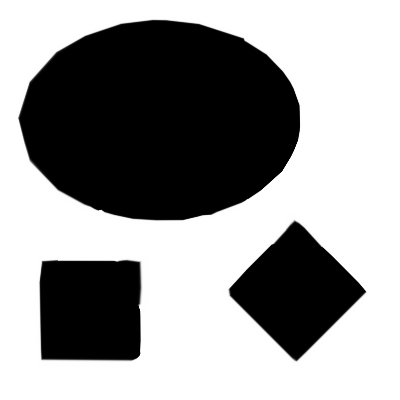

In [9]:
func FNN(ctx *context.Context, xys *Node) *Node {
    return fnn.New(ctx.In("fnn"), xys, /* ouputDim */1).NumHiddenLayers(3, 20).Done()
}

%%
DemoFn(FNN, /* numBatches */ 10, /* useCrossentropy */ true)

### BSpline-KAN

Training (25000 steps):  100% [========================================] (1667 steps/s) [step=24999] [loss+=0.001] [~loss+=0.001] [~loss=0.001]        ]        
Train: loss=float32(0.0011)
	Median training time: 523.595µs
Accuracy:	99.7%
# params:	1040



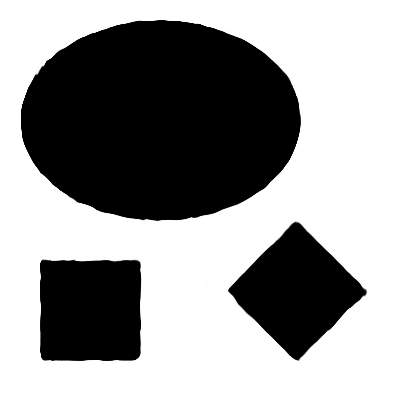

In [10]:
func BSplineKAN(ctx *context.Context, xys *Node) *Node {
    return kan.New(ctx.In("BSplineKan"), xys, 1).
        NumHiddenLayers(2, 10).
        NumControlPoints(6).
        UseResidual(true).
        Done()
}

%%
DemoFn(BSplineKAN, /* numBatches */ 10, /* useCrossentropy */ true)

### Rational Functions KAN (GR-KAN)

Training (25000 steps):  100% [========================================] (2295 steps/s) [step=24999] [loss+=0.003] [~loss+=0.005] [~loss=0.005]        ]        
Train: loss=float32(0.0029)
	Median training time: 380.413µs
Accuracy:	99.7%
# params:	1430



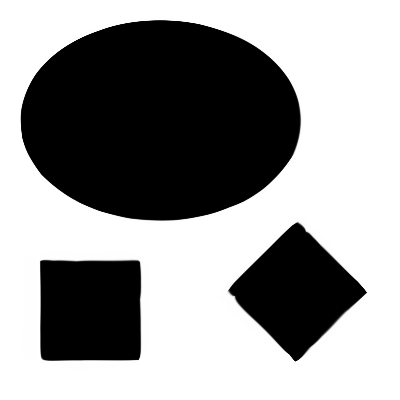

In [11]:
func GRKAN(ctx *context.Context, xys *Node) *Node {
    return kan.New(ctx.In("GRKAN"), xys, 1).
        Rational().
        NumHiddenLayers(2, 10).
        UseResidual(true).
        Done()
}

%%
DemoFn(GRKAN, /* numBatches */ 10, /* useCrossentropy */ true)

### Piecewise Linear KAN (PWL-KAN)

Training (25000 steps):  100% [========================================] (1776 steps/s) [step=24999] [loss+=0.006] [~loss+=0.008] [~loss=0.008]        ]        
Train: loss=float32(0.0061)
	Median training time: 447.651µs
Accuracy:	99.8%
# params:	3170



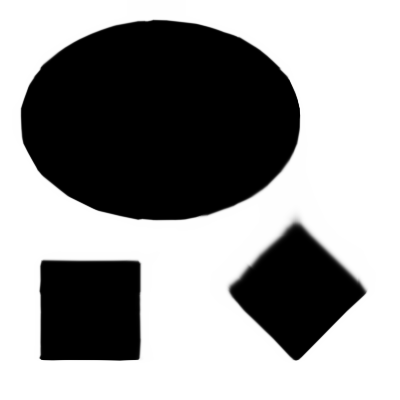

In [12]:
func PWLKAN(ctx *context.Context, xys *Node) *Node {
    ctx.SetParam(kan.ParamPWLSplitPointsTrainable, true)
    return kan.New(ctx.In("PWL-KAN"), xys, 1).
        PiecewiseLinear().
        NumHiddenLayers(2, 10).
        UseResidual(true).
        NumControlPoints(20).        
        Done()
}

%%
DemoFn(PWLKAN, /* numBatches */ 10, /* useCrossentropy */ true)

### Piecewise Constant KAN (Discrete-KAN)

Training (100000 steps):  100% [========================================] (1820 steps/s) [step=99999] [loss+=0.004] [~loss+=0.004] [~loss=0.004]        ]         
Train: loss=float32(0.0039)
	Median training time: 447.929µs
Accuracy:	96.6%
# params:	2443



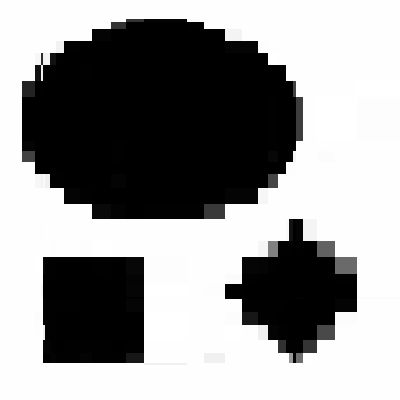

In [13]:
func DiscreteKAN(ctx *context.Context, xys *Node) *Node {
    ctx.SetParam(kan.ParamDiscreteSoftnessScheduleMin, 1e-5)
    return kan.New(ctx.In("DiscreteKAN"), xys, 1).
        Discrete().
        NumHiddenLayers(3, 5).
        UseResidual(true).
        NumControlPoints(30).
        DiscreteSoftness(0.2).
        DiscreteSplitsTrainable(true).
        DiscreteSoftnessScheduleType(kan.SoftnessScheduleExponential).
        Done()
}

%%
BaseNumSteps = 10_000
DemoFn(DiscreteKAN, /* numBatches */ 10, /* useCrossentropy */ false)